<a href="https://colab.research.google.com/github/sbrl/research-smflooding/blob/main/Flood_VADER_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports the requisite libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
import string
import nltk
import csv
import demoji
# demoji.download_codes()
from nltk.stem.wordnet import WordNetLemmatizer


# **Loading the flood dataset**

In [ ]:
flood_amt_df = pd.read_csv ('amt_dataset.csv')
flood_amt_df.shape

(2001, 31)

# **Text preprocessing User Defined Function**

In [ ]:
import json
import collections
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
from nltk.tokenize import TweetTokenizer
def text_preprocess(text):
    FLAGS = re.MULTILINE | re.DOTALL
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    text = re_sub(r"[A-Za-z]+[@#$%^&*()]+[A-Za-z]*","abuse")
    
    return  text #" ".join(tokens)


# **Review first five lines of the dataset**

In [ ]:
flood_amt_df.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.text,Answer.sentiment.label,Approve,Reject
0,3NKW03WTLM1Z6TH4TKC8TY4OO9ZQWU,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,26,0% (0/0),0% (0/0),0% (0/0),\NSW Flood Watch for Tumut,Neutral,NaN,NaN
1,3T2EL38U0MEEVTMU3P8UVHIVXB5QXN,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,10,0% (0/0),0% (0/0),0% (0/0),\@aWS0SA-bClBDsQietGuCGQ Hell,Negative,NaN,NaN
2,3U74KRR67MFMBF0IINFG2K2KF4UTNK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,28,0% (0/0),0% (0/0),0% (0/0),\@VXcGCrisx0PZSYeiwhBvUQ It has been planned s...,Slightly positive,NaN,NaN
3,3T5ZXGO9DEI30OM947WFS2Y65B3QZK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,18,0% (0/0),0% (0/0),0% (0/0),\@-E8ArkLysW1G-XzkHC7VPQ @n7fEXN3yCeJz09LGkqql...,Negative,NaN,NaN
4,3ZZAYRN1I6L4T00UJ2FTH92P5EZTOZ,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:54 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,29,0% (0/0),0% (0/0),0% (0/0),\I am a professional in digital marketing and ...,Slightly positive,NaN,NaN


# **Install the VADER Algorithm**

In [ ]:
!pip install vaderSentiment

# **Implement VADER Algorithm on the flood dataset**

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
for text in flood_amt_df['Input.text']:
    vs = analyzer.polarity_scores(text)
    print("{:-<65} {}".format(text, str(vs)))

\NSW Flood Watch for Tumut--------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
\@aWS0SA-bClBDsQietGuCGQ Hell------------------------------------ {'neg': 0.821, 'neu': 0.179, 'pos': 0.0, 'compound': -0.6808}
\@VXcGCrisx0PZSYeiwhBvUQ It has been planned since the 1600s and it well documented. I trust my own research. I have been let down too many times by science bias. I was once too a lover of science and an advocate for climate change. Freemasonry is to blame for this. They have planned this for centuries\"" {'neg': 0.061, 'neu': 0.77, 'pos': 0.169, 'compound': 0.7717}
\@-E8ArkLysW1G-XzkHC7VPQ @n7fEXN3yCeJz09LGkqql2A Do not---------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
\I am a professional in digital marketing and I will use my expertise to take your business to the next level\nClick on the link below to hire me\nhttps://t.co/98jzXtPtWK \n#GagaBySkyd \n#istanbulsoezlesmesi \n#kerabling \n#Lekkitollgate \n#lockdown2021 \n#Newsfi

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\675996\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **Preprocess the flood tweets data**

In [ ]:
flood_amt_df['cleaned_text'] = flood_amt_df['Input.text'].apply(text_preprocess)


# **Featuring Engineering - Using Polarity scores from the VADER sentiment classification**

In [ ]:
# Defining columns with negative, positive and neutral sentiment class
analyzer = SentimentIntensityAnalyzer()
flood_amt_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in flood_amt_df['Input.text']]
flood_amt_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in flood_amt_df['Input.text']]
flood_amt_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in flood_amt_df['Input.text']]
flood_amt_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in flood_amt_df['Input.text']]

In [ ]:
# Defining columns - scores, sentiment_score -positive and negative classes and sentiment_score - positive, neutral and negative classes
flood_amt_df['scores'] = flood_amt_df['Input.text'].apply(lambda text: sid.polarity_scores(text))
flood_amt_df['sentiment_score'] = flood_amt_df['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')
flood_amt_df['sentiment_score2'] = flood_amt_df['compound'].apply(lambda c: 'positive' if c > 0 else ('neutral' if c == 0 else 'negative'))

flood_amt_df.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Approve,Reject,cleaned_text,compound,neg,neu,pos,scores,sentiment_score,sentiment_score2
0,3NKW03WTLM1Z6TH4TKC8TY4OO9ZQWU,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,\NSW Flood Watch for Tumut,0.0000,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral
1,3T2EL38U0MEEVTMU3P8UVHIVXB5QXN,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,\<user>-bClBDsQietGuCGQ Hell,-0.6808,0.821,0.179,0.00,"{'neg': 0.821, 'neu': 0.179, 'pos': 0.0, 'comp...",negative,negative
2,3U74KRR67MFMBF0IINFG2K2KF4UTNK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,\<user> It has been planned since the <number>...,0.7717,0.065,0.755,0.18,"{'neg': 0.065, 'neu': 0.755, 'pos': 0.18, 'com...",positive,positive
3,3T5ZXGO9DEI30OM947WFS2Y65B3QZK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,\@-E<number>ArkLysW<number>G-XzkHC<number>VPQ ...,0.0000,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral
4,3ZZAYRN1I6L4T00UJ2FTH92P5EZTOZ,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:54 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,NaN,NaN,\I am a professional in digital marketing and ...,0.0000,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral


In [ ]:
flood_amt_df['Answer.sentiment.label'].unique()

array(['Neutral', 'Negative', 'Slightly positive', 'Slightly negative',
       'Positive'], dtype=object)

In [ ]:
flood_amt_df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.text',
       'Answer.sentiment.label', 'Approve', 'Reject', 'cleaned_text',
       'compound', 'neg', 'neu', 'pos', 'scores', 'sentiment_score',
       'sentiment_score2'],
      dtype='object')

In [ ]:
#  Encoding the sentiment labels
sent_score = []

for comp in flood_amt_df['compound']:
    if comp > 0:
        sent_score.append('pos')
    elif comp == 0:
        sent_score.append('neu')
    else:
        sent_score.append('neg')
    
flood_amt_df['sent_score']  = sent_score



label_1 = []
sentiment_score_1 =[]

for index, row in flood_amt_df.iterrows():
    if (row['Answer.sentiment.label'] == 'Positive') | (row['Answer.sentiment.label'] == 'Slightly positive'):
        label_1.append(1)
    elif row['Answer.sentiment.label'] == 'Neutral':
        label_1.append(0)
    else:
        label_1.append(-1)
        
    if row['sentiment_score2'] == 'positive':
        sentiment_score_1.append(1)
    elif row['sentiment_score2'] == 'neutral':
        sentiment_score_1.append(0)
    else:
        sentiment_score_1.append(-1)
    
flood_amt_df['label_1']  = label_1
flood_amt_df['sentiment_score_1']  = sentiment_score_1

In [ ]:
sent_score_comp = []

for index, row in flood_amt_df.iterrows():
    if row['label_1'] == row['sentiment_score_1']:
        sent_score_comp.append('same')
    else:
        sent_score_comp.append('different')
    
flood_amt_df['sent_score_comp']  = sent_score_comp


In [ ]:
flood_amt_df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.text',
       'Answer.sentiment.label', 'Approve', 'Reject', 'cleaned_text',
       'compound', 'neg', 'neu', 'pos', 'scores', 'sentiment_score',
       'sentiment_score2', 'sent_score', 'label_1', 'sentiment_score_1',
       'sent_score_comp'],
      dtype='object')

In [ ]:
flood_amt_df.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,neg,neu,pos,scores,sentiment_score,sentiment_score2,sent_score,label_1,sentiment_score_1,sent_score_comp
0,3NKW03WTLM1Z6TH4TKC8TY4OO9ZQWU,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral,neu,0,0,same
1,3T2EL38U0MEEVTMU3P8UVHIVXB5QXN,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,0.821,0.179,0.00,"{'neg': 0.821, 'neu': 0.179, 'pos': 0.0, 'comp...",negative,negative,neg,-1,-1,same
2,3U74KRR67MFMBF0IINFG2K2KF4UTNK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,0.065,0.755,0.18,"{'neg': 0.065, 'neu': 0.755, 'pos': 0.18, 'com...",positive,positive,pos,1,1,same
3,3T5ZXGO9DEI30OM947WFS2Y65B3QZK,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:53 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral,neu,-1,0,different
4,3ZZAYRN1I6L4T00UJ2FTH92P5EZTOZ,3KTAGXQO2Z01OW2SU2UAVPZHRZZKGN,Sentiment analysis,Sentiment analysis,"sentiment, text",$0.05,Fri Apr 01 04:48:54 PDT 2022,1,BatchId:4705143;OriginalHitTemplateId:928390909;,60,...,0.000,1.000,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",positive,neutral,neu,1,0,different


In [ ]:
flood_amt_df = flood_amt_df[['Input.text', 'cleaned_text', 'Answer.sentiment.label', 'sentiment_score', 'scores', 'sent_score', 'sent_score_comp','label_1',
       'sentiment_score_1']]
flood_amt_df.head()

,Input.text,cleaned_text,Answer.sentiment.label,sentiment_score,scores,sent_score,sent_score_comp,label_1,sentiment_score_1
0,\NSW Flood Watch for Tumut,\NSW Flood Watch for Tumut,Neutral,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,same,0,0
1,\@aWS0SA-bClBDsQietGuCGQ Hell,\<user>-bClBDsQietGuCGQ Hell,Negative,negative,"{'neg': 0.821, 'neu': 0.179, 'pos': 0.0, 'comp...",neg,same,-1,-1
2,\@VXcGCrisx0PZSYeiwhBvUQ It has been planned s...,\<user> It has been planned since the <number>...,Slightly positive,positive,"{'neg': 0.065, 'neu': 0.755, 'pos': 0.18, 'com...",pos,same,1,1
3,\@-E8ArkLysW1G-XzkHC7VPQ @n7fEXN3yCeJz09LGkqql...,\@-E<number>ArkLysW<number>G-XzkHC<number>VPQ ...,Negative,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,-1,0
4,\I am a professional in digital marketing and ...,\I am a professional in digital marketing and ...,Slightly positive,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,1,0


# **Visualization of Comparison of Hackaton, AMT & VADER Sentiments**

# **Hackaton Sentiments Visualization**

<AxesSubplot:title={'center':'Flood - AMT Sentiment Analysis - Hackathon'}>

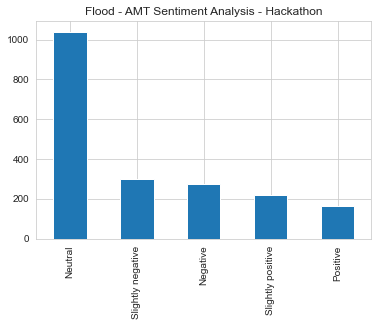

In [ ]:
flood_amt_df['Answer.sentiment.label'].value_counts().plot(kind='bar',title="Flood - AMT Sentiment Analysis - Hackathon")

# **AMT Sentiments Visualization**

<AxesSubplot:title={'center':'Flood - AMT Sentiment Analysis - VADER'}>

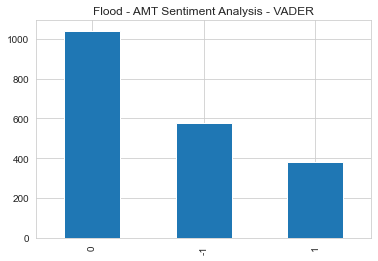

In [ ]:
flood_amt_df['label_1'].value_counts().plot(kind='bar',title="Flood - AMT Sentiment Analysis - VADER")

# **VADER Sentiments Visualization**

<AxesSubplot:title={'center':'Flood - AMT Sentiment Analysis 2 - VADER'}>

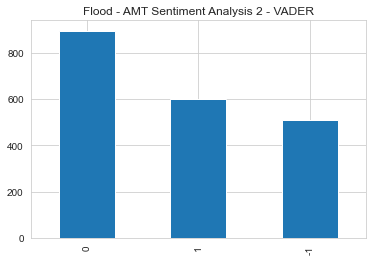

In [ ]:
flood_amt_df['sentiment_score_1'].value_counts().plot(kind='bar',title="Flood - AMT Sentiment Analysis 2 - VADER")

In [ ]:
grouped_multiple

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
y_actu = flood_amt_df['label_1']
y_pred = flood_amt_df['sentiment_score_1']
confusion_matrix(y_actu, y_pred)


array([[266, 193, 119],
       [188, 592, 260],
       [ 54, 110, 219]], dtype=int64)

In [ ]:
diff_flood_amt_df = flood_amt_df[flood_amt_df['sent_score_comp'] == 'different']
print(f'Total number of disimilar sentiment: {len(diff_flood_amt_df)}')
diff_flood_amt_df

Total number of disimilar sentiment: 924


,Input.text,cleaned_text,Answer.sentiment.label,sentiment_score,scores,sent_score,sent_score_comp,label_1,sentiment_score_1
3,\@-E8ArkLysW1G-XzkHC7VPQ @n7fEXN3yCeJz09LGkqql...,\@-E<number>ArkLysW<number>G-XzkHC<number>VPQ ...,Negative,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,-1,0
4,\I am a professional in digital marketing and ...,\I am a professional in digital marketing and ...,Slightly positive,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,1,0
6,\@3LlNeP_Vo2yjndRIDJISAw @hnNjuTCG1kjJqgp4KUmh...,\<user> <user> That article is a year earlier....,Slightly positive,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,1,0
7,\Three people watching the floodwaters in More...,\Three people watching the floodwaters in More...,Neutral,positive,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...",pos,different,0,1
8,\@_9kBxriqwfNSYzmv_CKLaQ @UKwJyPPDeGxEI07MTsgD...,\<user> <user> <user> She’ll have some new nei...,Slightly positive,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,1,0
...,...,...,...,...,...,...,...,...,...
1993,"\@wYJBZDNLEOuMTFmBRB7biQ im so sad abt this\""""","\<user> im so sad abt this\""""",Neutral,negative,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",neg,different,0,-1
1994,\@hjyTLWdLjYNp8mjWoQowUQ @YDqUUairwTDb-thN_zUO...,\<user> <user>-thN_zUOgg <user> It’s not fake ...,Neutral,positive,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",pos,different,0,1
1995,\@oyJBs748UZ9O9yDynq_rxQ @UKwJyPPDeGxEI07MTsgD...,\<user> <user> My sister in law lives in Taree...,Negative,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,different,-1,0
1997,\The continued escalation of #Deforestation is...,\The continued escalation of #Deforestation is...,Neutral,negative,"{'neg': 0.252, 'neu': 0.642, 'pos': 0.106, 'co...",neg,different,0,-1


In [ ]:
# Saving the VADER Sentiment classification
flood_amt_df.to_csv(r'C:/Temp/flood_amt_labelled.csv')  